# Práctica 4: Extracción de caracteristicas usando SIFT

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from skimage import color

In [2]:
def segment_coins(img, filt):
    coins_mask = []
    full_mask = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if filt == 'gaussian':
        gray = cv2.GaussianBlur(gray, (15,15), 2, 2)
    elif filt == 'median':
        gray = cv2.medianBlur(gray, 9)
    # Binarizacion usando el metodo de Otsu 
    # determina automaticamente el umbral optimo
    _, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # Transformacion morfologica: closing
    # 20, 20
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((5,5), np.uint8), iterations = 2)
    # Transformacion morfologica: opening
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((20,20), np.uint8), iterations = 2)
    # Transformada de distancia
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    # Descartar el fondo de la imagen
    _, sure_fg = cv2.threshold(dist_transform,0.4*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    # Transformacion morfolofica: dilatacion
    dilation = cv2.dilate(sure_fg, np.ones((33,33), np.uint8), iterations=3)
    # Colocar etiquetas a cada moneda en la imagen
    # (agregar un numero entero a cada region)
    ret, markers = cv2.connectedComponents(dilation)
    full_mask.append(np.uint8(markers))
    # Creacion de las mascaras individuales, de cada moneda
    for mark in range(1, ret):
        coord_mask = np.where(markers==mark)
        coord_mask = [(x, y) for x, y in zip(coord_mask[0], coord_mask[1])]
        mask = np.zeros(gray.shape)
        for x, y in coord_mask:
            mask[x,y] = 1
        coins_mask.append(np.uint8(mask))
    return full_mask[0], coins_mask

In [3]:
def cmask(imgSet, f=None):
    '''
        Toma como entrada una imagen y regresa sus caracteristicas usando SIFT
    '''
    # Objeto sift para extraer caracteristicas
    sift = cv2.xfeatures2d.SIFT_create()
    cmasks = []             # Se almacenan 12 mascaras por cada imagen. dim=3x12
    fmasks = []             # Mascaras completas por imagen. dim=3x1
    keypoints = []          # Keypoints de cada mascara
    descriptors = []        # Descriptores de cada mascara. dim=3x12x2
    f_keypoints = []        # Keypoints de cada mascara completa dim=3
    for img in imgSet:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if f == None:
            full_mask, coins_mask = segment_coins(img, 'gaussian')
        elif f == 'median':
            full_mask, coins_mask = segment_coins(img, 'median')
        cmasks.append(coins_mask)
        fmasks.append(full_mask)
        # iterar en cada una de las 12 mascaras x imagen
        for mask in coins_mask:
            kp, desc = sift.detectAndCompute(gray, mask)
            descriptors.append([mask, desc])
            keypoints.append([mask, kp])
        kp, desc = sift.detectAndCompute(gray, full_mask)
        f_keypoints.append([full_mask, kp])
            
    return descriptors, keypoints, f_keypoints

In [4]:
# Lectura de las imagenes enfocadas sin ruido
imgs = []
imgs.append(cv2.imread('img/IMG_A_Foco.JPG', 1))
imgs.append(cv2.imread('img/IMG_B_Foco.JPG', 1))
imgs.append(cv2.imread('img/IMG_C_Foco.JPG', 1))

In [5]:
# Lectura de las imagenes enfocadas con ruido gaussiano
imgsNoiseG = []
imgsNoiseG.append(cv2.imread('img/IMG_A_Foco_gaussian.jpg', 1))
imgsNoiseG.append(cv2.imread('img/IMG_B_Foco_gaussian.jpg', 1))
imgsNoiseG.append(cv2.imread('img/IMG_C_Foco_gaussian.jpg', 1))

In [6]:
# Lectura de las imagenes enfocadas con ruido impulsivo
imgsNoiseI = []
imgsNoiseI.append(cv2.imread('img/IMG_A_Foco_saltPepper.jpg', 1))
imgsNoiseI.append(cv2.imread('img/IMG_B_Foco_saltPepper.jpg', 1))
imgsNoiseI.append(cv2.imread('img/IMG_C_Foco_saltPepper.jpg', 1))

In [7]:
# Conversion de canal BGR A RGB
for img, imgNoise, i in zip(imgs, imgsNoiseG, range(3)):
        imgs[i] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgsNoiseG[i] = cv2.cvtColor(imgNoise, cv2.COLOR_BGR2RGB)

#### Extraccion de caracteristicas de las imagenes de entrenamiento

In [8]:
# Usar las imagenes A y B enfocadas como entrenamiento
imgsTraining = []
imgsTraining.append(imgs[:][0])
imgsTraining.append(imgs[:][1])

In [9]:
descriptorsTraining, keypointsTraining, f_keypointsTraining = cmask(imgsTraining)

In [10]:
# Obtener imagenes con los keypoints marcados
imgsKeypointTraining = []
# Primera imagen
for mask, kpt in keypointsTraining[0:12]:
    imgsTraining[0] = cv2.drawKeypoints(imgsTraining[0], kpt, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgsKeypointTraining.append(imgsTraining[0])
    
# Segunda imagen
for mask, kpt in keypointsTraining[12:24]:
    imgsTraining[1] = cv2.drawKeypoints(imgsTraining[1], kpt, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgsKeypointTraining.append(imgsTraining[1])

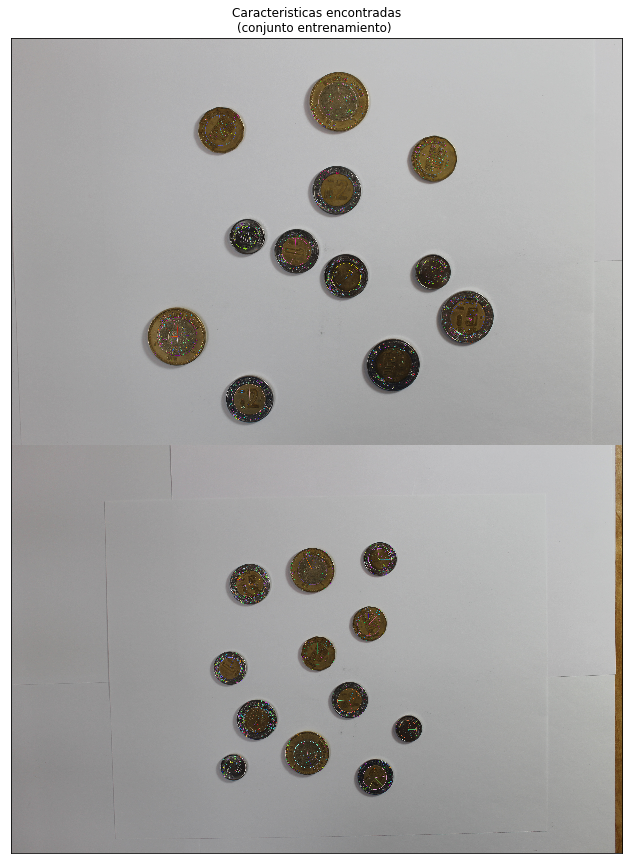

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(np.vstack((imgsKeypointTraining[0], imgsKeypointTraining[1])))
plt.title('Caracteristicas encontradas\n(conjunto entrenamiento) ')
plt.xticks([])
plt.yticks([])
plt.show()

#### Etiquetar las imagenes de entrenamiento

In [12]:
#descriptorsTraining[0][0] -> mascara
#descriptorsTraining[0][1] -> descriptores
# ...
#descriptorsTraining[23][1]

In [ ]:
coinsA = plt.figure(figsize=(15,15))
coinsA.suptitle('Monedas imagen A')
for i in range(0, 12):
    plt.subplot(4,3,i+1)
    plt.imshow(color.label2rgb(descriptorsTraining[i][0], image=imgsTraining[0]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [14]:
# Crear vector donde se almacenan los 24 descriptores de entrenamiento
Xtrain = []
for i in range(24):
    Xtrain.append(descriptorsTraining[i][1])
Xtrain = np.array(Xtrain)

In [15]:
# Crear vector objetivo con las clases a las que pertenecen las monedas
classes = {
    0:'0.50',
    1:'1',
    2:'2',
    3:'5',
    4:'10'
}

target = np.zeros((24,), np.uint8())
# Monedas imagen 1
target[0] = 4
target[1] = 0
target[2] = 0
target[3] = 2
target[4] = 0
target[5] = 1
target[6] = 1
target[7] = 0
target[8] = 3
target[9] = 4
target[10] = 3
target[11] = 2
# Monedas imagen 2
target[12] = 4
target[13] = 0
target[14] = 0
target[15] = 10
target[16] = 10
target[17] = 10
target[18] = 10
target[19] = 10
target[20] = 10
target[21] = 10
target[22] = 10
target[23] = 10

In [16]:
# El objeto brute-force es creado para comparar las features de cada imagen
# que encontro el algoritmo SIFT.
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

In [17]:
#matches = bf.match(desc1, desc2)
#matches = sorted(matches, key=lambda m: m.distance)

In [18]:
#print('Coincidencias encontradas = ', len(matches))

In [19]:
#print([m.distance for m in matches[:10]])

In [20]:
# Crear una imagen donde se indican las coincidencias que hay entre los
# features de las dos imagenes
#matching_result = cv2.drawMatches(img, kp1, img2, kp2, matches[:10], None)

In [21]:
#plt.figure(figsize=(10, 10))
#plt.imshow(matching_result, cmap='gray')
#plt.show()

## Testing

In [22]:
full_mask, coins_mask = segment_coins(imgs[0])

TypeError: segment_coins() missing 1 required positional argument: 'filt'

In [ ]:
print(len(coins_mask))
plt.figure(figsize=(8,8))
plt.imshow(full_mask, cmap='jet')
plt.show()

### Referencias

https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html

https://www.youtube.com/watch?v=Fe-KWKPk9Zc (feature matching)

https://www.youtube.com/watch?v=USl5BHFq2H4 (feature detection)